In [53]:
settings = {
    "xsrf_cookies": False,
}

In [1]:
import pandas as pd
import itertools
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import numpy as np

#load data labels and RDkit fingerprints
#using pickled data
with open('../dumps/combined_dataset.pkl', 'rb') as f:
      data = pickle.load(f)

N=len(data.loc[data['target'] == 'TMPRSS2']) #number of compounds tested against TMPRSS2 itself
n_test=round(N/3) #withold for testing
fp_dark=np.load('../dumps/DarkChemicalMatter_morgan_fingerprints.npz')
fp_dark=fp_dark['fps']


In [2]:
#convert to array
#using merged data from pickle
datalabels=list(data['target'])
fps_merged=np.stack(data['morgan_fingerprint'])
ac_merged_scaled=np.asarray(data['acvalue_scaled_to_tmprss2'])
cids=list(data['cid'])
act_list=list(data['activity_target'])
activity_scaled=[]
activity=[]
for i in range(len(act_list)):
    if act_list[i] == 'Active':
        activity.append(1)
    else:
        activity.append(0)
    if ac_merged_scaled[i]>0:
        if act_list[i] == 'Active':
            activity_scaled.append(1)
        else:
            activity_scaled.append(0)
#alternatively
ac_merged=np.asarray(data['acvalue_target'])
#keep only the positive vals in ac_merged
fps_merged_scaled=fps_merged[ac_merged_scaled>0]
cids_scaled=[cid for i, cid in enumerate(cids) if ac_merged_scaled[i]>0]
ac_merged_scaled=ac_merged[ac_merged_scaled>0]


activity=np.array(activity)
ac_merged=np.array(ac_merged)
ac_merged=-np.log10(ac_merged)
activity_scaled=np.array(activity_scaled)
ac_merged_scaled=np.array(ac_merged_scaled)
ac_merged_scaled=-np.log10(ac_merged_scaled)

/Users/schu3/.conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/schu3/.conda/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater


In [3]:
#split train and test 
#half of tmprss2 active compounds to each set
import random
s=np.arange(N)
random.shuffle(s)
cut=n_test
test=s[0:cut]
train=s[cut::]

#add dark data. here we generate 1 test set that includes only data from TMPRSS2 dataset + negative examples
#and training data culled from all protein datasets, + negative examples that are not in the test set.
#the samples from TMPRSS2, and negative examples are sampled randomly to be about 50 percent.
s=np.arange(len(fp_dark))
random.shuffle(s)
cut=round(len(fp_dark)/2)
test_dark=s[0:cut]
train_dark=s[cut::]
X_test=np.concatenate((fps_merged_scaled[test], fp_dark[test_dark]))
X_train=np.concatenate((fps_merged_scaled[train], fps_merged_scaled[92::], fp_dark[train_dark]))
y_train=np.concatenate((activity_scaled[train], activity_scaled[92::], np.zeros([len(train_dark)])))
y2_train=np.concatenate((ac_merged_scaled[train], ac_merged_scaled[92::], np.zeros([len(train_dark)])))
y_test=np.concatenate((activity_scaled[test], np.zeros([len(test_dark)])))
y2_test=np.concatenate((ac_merged_scaled[test],np.zeros([len(test_dark)])))

X_test_u=np.concatenate((fps_merged[test], fp_dark[test_dark]))
X_train_u=np.concatenate((fps_merged[train], fps_merged[92::], fp_dark[train_dark]))
y_train_u=np.concatenate((activity[train], activity[92::], np.zeros([len(train_dark)])))
y2_train_u=np.concatenate((ac_merged[train], ac_merged[92::], np.zeros([len(train_dark)])))
y_test_u=np.concatenate((activity[test], np.zeros([len(test_dark)])))
y2_test_u=np.concatenate((ac_merged[test],np.zeros([len(test_dark)])))

In [4]:
#generate big training set
X_train_all=np.concatenate((fps_merged_scaled, fp_dark))
y2_train_all=np.concatenate((ac_merged_scaled, np.zeros([len(fp_dark)])))
y_train_all=np.concatenate((activity_scaled, np.zeros([len(fp_dark)])))

In [61]:
###YOU CAN SKIP THIS STEP IF NOT RUNNING THE CLASSIFIER###
#generate RF: classifier based on whether or not compound is thought to be active.
#split training and test set, keep random_state to be an integer for reproducibility
#train the forest (this can take a while)
#in the example, about 2/3 go to training and 1/3 go to test
#X_train, X_test, y_train, y_test = train_test_split(fps_merged,activity, test_size=0.33, random_state=39)
rf=RandomForestClassifier(verbose=2, n_estimators=100, random_state=111)
rf.fit(np.asarray(X_train), np.asarray(y_train))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=111,
                       verbose=2, warm_start=False)

In [62]:
y_pred=rf.predict(X_test)
print(rf.score(X_test, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


0.999971310123223


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished


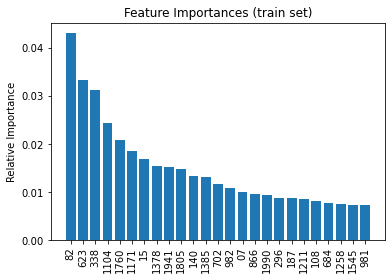

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     69670
         1.0       0.95      1.00      0.98        41

    accuracy                           1.00     69711
   macro avg       0.98      1.00      0.99     69711
weighted avg       1.00      1.00      1.00     69711



In [63]:
#get the index of the features (of RDkit fingerprint) that were important
importances = rf.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()
#output metrics
print(classification_report(y_test, y_pred))


In [19]:
#REGRESSION
#testing, but without the negative training examples.
#take the same random vector of subset of true TMPSSR2 values as test set, and everything else i.e.
# the ac values from assay against a different membrane protein is combined into training set
#drop nan values
X_test_reg=fps_merged[test]
X_train_reg=np.concatenate((fps_merged[train], fps_merged[92::]))
y2_train_reg=np.concatenate((ac_merged[train], ac_merged[92::]))
y2_test_reg=ac_merged[test]
nan_array=np.isnan(y2_train_reg)
X_train_reg=X_train_reg[~nan_array]
y2_train_reg=y2_train_reg[~nan_array]
#and generate for scaled arrays
X_train_reg_scaled=np.concatenate((fps_merged_scaled[train], fps_merged_scaled[92::]))
y2_train_reg_scaled=np.concatenate((ac_merged_scaled[train], ac_merged_scaled[92::]))

#here we have trained 2 regressors
#rg_pos_only <- no negative training examples and unscaled data
#rg_pos_only_scaled <- no negative training examples and scaled data
rg_pos_only=RandomForestRegressor(verbose=2, n_estimators=50, random_state=111)
rg_pos_only_scaled=RandomForestRegressor(verbose=2, n_estimators=50, random_state=111)
rg_pos_only.fit(np.asarray(X_train_reg), np.asarray(y2_train_reg))
rg_pos_only_scaled.fit(np.asarray(X_train_reg_scaled), np.asarray(y2_train_reg_scaled))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 4

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.9s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [24]:
from sklearn.metrics import r2_score
#the test set only contains unscaled values from TMPRSS2 assay so its the same
#scaled data, regression on positives
y_pred_regr_pos=rg_pos_only.predict(X_test_reg)
print(r2_score(y2_test_reg, y_pred_regr_pos))

#unscaled data, regression on positives
y_pred_regr_scaled_pos=rg_pos_only_scaled.predict(X_test_reg)
print(r2_score(y2_test_reg, y_pred_regr_scaled_pos))

#not great, but slightly better score for "scaled" dataset.

0.1279129543810411
0.21024809198743022


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


In [17]:
#bloc for some hyperparameter tuning
#to add stuff later
from pprint import pprint
print('Parameters currently in use:\n')
pprint(rg_scaled.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 111,
 'verbose': 2,
 'warm_start': False}


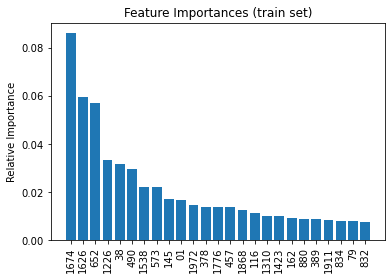

In [25]:
importances = rg_pos_only_scaled.feature_importances_
featurenums = np.array([str(x).zfill(2) for x in range(len(importances))])
indices = np.argsort(importances)[::-1][0:25]#get the 25 most important features
plt.title('Feature Importances (train set)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.ylabel('Relative Importance')
plt.xticks(range(len(indices)), featurenums[indices], rotation=90)
plt.show()

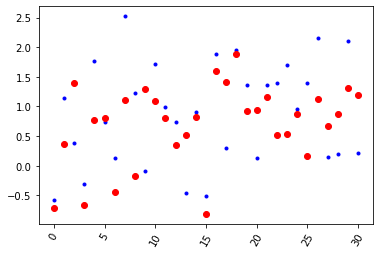

In [26]:
#plots, first is for unscaled regression
plt.plot(y2_test_reg, 'b.', label = 'actual')
# Plot the predicted values
plt.plot(y_pred_regr_pos, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 

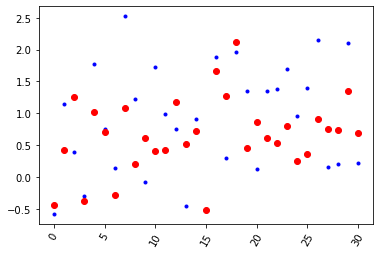

In [28]:
#second is for scaled regression
plt.plot(y2_test_reg_scaled, 'b.', label = 'actual')
# Plot the predicted values
plt.plot(y_pred_regr_scaled_pos, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
#note does a slightly better job at predicting the low ac-val which is what we care about?
#mumber 13 has low ac value and is overpredicted by model always.

In [ ]:
#now fit everything
#no negative training examples
#all training data from 
rg_all=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_all.fit(np.asarray(X_train_all), np.asarray(y2_train_all))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.4s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100


In [29]:
reframe=np.load('../dumps/reframe_fp.npz')
molnames=reframe['arr_1']
reframe=reframe['arr_0']

screening=np.load('../dumps/screening_fp.npz')
molnames_all=screening['arr_1']
screening=screening['arr_0']

In [30]:
rg_all=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_all.fit(np.asarray(fps_merged_scaled), np.asarray(ac_merged_scaled)) #use scaled bc it performs slightly better in the validation case

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=111, verbose=2, warm_start=False)

In [18]:
# Open the file to save as pkl file
rf_pkl_filename = 'rf_reg_20200616.pkl'
rf_model_pkl = open(rf_pkl_filename, 'wb')
pickle.dump(rg_all2, rf_model_pkl)
# Close the pickle instances
rf_model_pkl.close()

In [31]:
predicted_activity=rg_all.predict(screening)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


['Nafamostat' 'Patamostat' 'Camostat' 'Nafamostat' 'nafamostat'
 'nafamostat' 'nafamostat' 'NO-ASA' 'Nitroaspirin' 'TO-195'
 'Sepimostat mesilate'
 '1-[(4S)-4-amino-5-(1,3-benzothiazol-2-yl)-5-oxopentyl]guanidine'
 'TG-100801' 'TG-100801' 'estradiol-benzoate' 'Estradiol benzoate'
 'RWJ-56423' 'BCX-170' 'RWJ-51084' 'micafungin']
[3.04568908 2.41391828 2.30040823 2.01766184 2.01766184 2.01766184
 2.01766184 1.88153621 1.88153621 1.86249965 1.84810366 1.72133514
 1.70838962 1.70838962 1.66667296 1.66635583 1.6545487  1.61406812
 1.57920011 1.53459798]


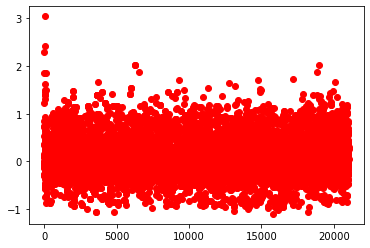

In [40]:
#plot and print the top 20 hits
#plotted values are in -log10 form (higher is better)
plt.plot(predicted_activity, 'ro', label = 'prediction')
indices=np.argpartition(predicted_activity, -20)[-20:]
print(molnames_all[indices][np.argsort(predicted_activity[indices])][::-1])
print(np.sort(predicted_activity[indices])[::-1])

In [81]:
#old code snippet for running unscaled values
nan_array=np.isnan(ac_merged)
fps_merged=fps_merged[~nan_array]
ac_merged=ac_merged[~nan_array]
rg_all3=RandomForestRegressor(verbose=2, n_estimators=100, random_state=111)
rg_all3.fit(np.asarray(fps_merged), np.asarray(ac_merged))